# Asynchronous and concurrent execution on GPUs
>*Melina Abeling, Julian Aeissen, Michele Pagani*. Supervised by *Oliver Fuhrer*

*GPUs allow for asynchronous (CPU simply launches work on GPU and then continues) and concurrent (multiple tasks are executed in parallel on the GPU) execution. In this project you will implement a simple stencil program and investigate performance using different stencil motifs as a function of grid size and amount of concurrency. It is foreseen to use either CuPy or CUDA for this project.*


---

## Introduction
*TODO*

---

## Methods
*TODO*
> see below used parameters

In [17]:
# Imports
import time
import numpy as np
import numpy as np
try:
    import cupy as cp
except ImportError:
    cp = np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import math

from utils import (
    boxplot_options,
    gaussian_5x5_stencil_2d,
    jacobi_stencil_2d,
    update_halo,
    get_initial_field_square,
    get_initial_field_grid,
    compute_gpu_2d
)

In [18]:
def get_asnumpy(z):
    try:
        return z.get()
    except AttributeError:
        return z


In [23]:
# Setup
step_stencil_a = jacobi_stencil_2d
step_stencil_b = gaussian_5x5_stencil_2d

n_iter = 1000
n_iter_stats = 10
n_halo_a = 1
n_halo_b = 2

### Initial fields
*TODO*
> square and grid, to better check the stencil and computations correctness

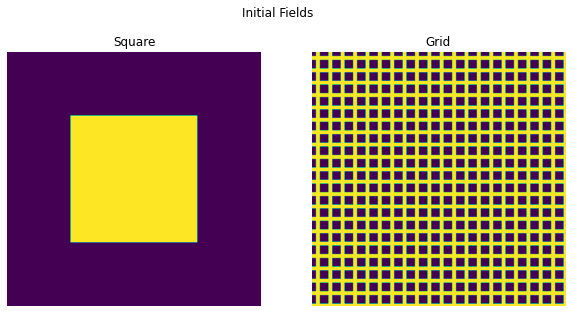

In [24]:
# Plots
fig, (axA, axB) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Initial Fields")

# Settings
field_size_demo = (1024, 1024)

# Plotting square field
field_demo_square = get_asnumpy(get_initial_field_square(field_size_demo, n_halo_a))
axA.imshow(field_demo_square)
axA.set_title("Square")
axA.set_axis_off()

# Plotting grid field
field_demo_grid = get_asnumpy(get_initial_field_grid(field_size_demo, n_halo_a, spacing=50))
axB.imshow(field_demo_grid)
axB.set_title("Grid")
axB.set_axis_off()


### Stencils
*TODO*
> 2 different stencil: jacobi (small) and gaussian 5x5 (bigger) to see influence of different sized stencil

We use two different stencils of different size in order to see the influence they have on the preformance of GPU execution. 

#### 2D Jacobi stencil

The Jacobi Stencil calculates a weighted average of nearest neighbours and the center grid points and is therefore a 5 point stencil.
In one time step two multiplication and 4 additions are performed. With double precision numbers at least 8 bytes have to be read or written (one number), yielding an Arithmetic Intensity of <0.5 FLOP/Byte
 

![Jacobi](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/2D_von_Neumann_Stencil.svg/220px-2D_von_Neumann_Stencil.svg.png)

**Effect of the Jacobi Stencil after 1000 iterations**

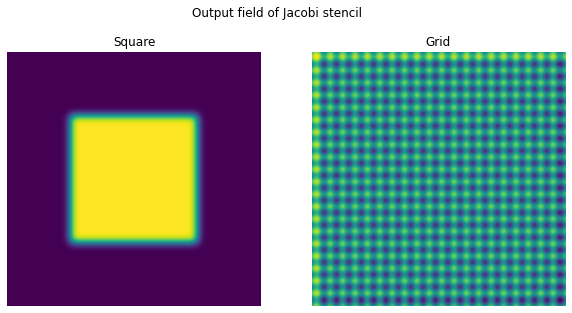

In [26]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Output field of Jacobi stencil")

# Compute square
field_a_square = get_initial_field_square(field_size_demo, n_halo_a)
in_field_a_square = cp.copy(field_a_square)
out_field_a_square = cp.copy(in_field_a_square)
for iter in range(n_iter):
    update_halo(in_field_a_square, n_halo_a)
    step_stencil_a(
        in_field_a_square,
        out_field_a_square[
            n_halo_a: -n_halo_a,
            n_halo_a: -n_halo_a,
        ],
        n_halo_a
    )

    # Update out_field
    if iter < n_iter - 1:
        in_field_a_square, out_field_a_square = out_field_a_square, in_field_a_square


# Compute grid
field_a_grid = get_initial_field_grid(field_size_demo, n_halo_a, spacing=50)
in_field_a_grid = cp.copy(field_a_grid)
out_field_a_grid = cp.copy(in_field_a_grid)
for iter in range(n_iter):
    update_halo(in_field_a_grid, n_halo_a)
    step_stencil_a(
        in_field_a_grid,
        out_field_a_grid[
            n_halo_a: -n_halo_a,
            n_halo_a: -n_halo_a,
        ],
        n_halo_a
    )

    # Update out_field
    if iter < n_iter - 1:
        in_field_a_grid, out_field_a_grid = out_field_a_grid, in_field_a_grid


# Plotting square field
ax1.imshow(get_asnumpy(out_field_a_square))
ax1.set_title("Square")
ax1.set_axis_off()

# Plotting grid field
ax2.imshow(get_asnumpy(out_field_a_grid))
ax2.set_title("Grid")
ax2.set_axis_off()


#### Gaussian 5x5 stencil
The gaussian 5x5 stencil on the other hand is much larger, being a 25 point stencil. It is a discrete approximation of the 2D Gaussian filter/blurr. In one time step/grid update 24 FLOP are performed per grid point (addition or multiplication or addition followed by multiplication).
Again at least one new number is written or read yielding (with double precision) 
an intensity of < 3 FLOP/Byte which can be considerably larger than for the smaller Jacobi stencil.

> approximation of gaussian blur with 5x5 stencil

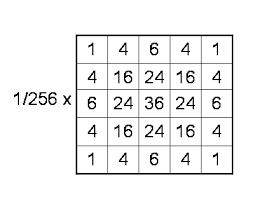

**Effect of the Gaussian blurr after 1000 iterations**

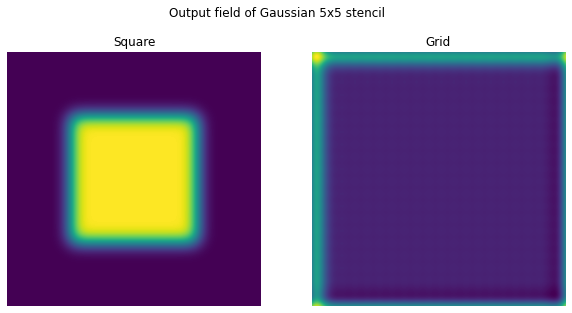

In [16]:
# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Output field of Gaussian 5x5 stencil")

# Compute square
field_b_square = get_initial_field_square(field_size_demo, n_halo_b)
in_field_b_square = cp.copy(field_b_square)
out_field_b_square = cp.copy(in_field_b_square)
for iter in range(n_iter):
    update_halo(in_field_b_square, n_halo_b)
    step_stencil_b(
        in_field_b_square,
        out_field_b_square[
            n_halo_b: -n_halo_b,
            n_halo_b: -n_halo_b,
        ],
        n_halo_b
    )

    # Update out_field
    if iter < n_iter - 1:
        in_field_a_square, out_field_b_square = out_field_b_square, in_field_b_square


# Compute grid
field_b_grid = get_initial_field_grid(field_size_demo, n_halo_b, spacing=50)
in_field_b_grid = cp.copy(field_b_grid)
out_field_b_grid = cp.copy(in_field_b_grid)
for iter in range(n_iter):
    update_halo(in_field_b_grid, n_halo_b)
    step_stencil_b(
        in_field_b_grid,
        out_field_b_grid[
            n_halo_b: -n_halo_b,
            n_halo_b: -n_halo_b,
        ],
        n_halo_b
    )

    # Update out_field
    if iter < n_iter - 1:
        in_field_b_grid, out_field_b_grid = out_field_b_grid, in_field_b_grid


# Plotting square field
ax1.imshow(get_asnumpy(out_field_b_square))
ax1.set_title("Square")
ax1.set_axis_off()

# Plotting grid field
ax2.imshow(get_asnumpy(out_field_b_grid))
ax2.set_title("Grid")
ax2.set_axis_off()


### GPU parallelization
*TODO*
> tiling the field in equal portions
> analyzing 2 different things: 
> - difference in performance with different levels of parallelization (GPU level vs Stream level)  ( 1 tile per stream)
> - parallization of multiple independent tasks with streams (fixed number of tiles, different subdivision of them in the streams)

Since we want to investigate the impact on performance of different levels of concurrency on the GPU, for this end we take two approaches. First, we compare the difference in performance with different levels of parallelization, i.e. divide the total field into a varying number of tiles. Each tile is assigned a different stream on the GPU.
Second again the field is subdivided into tiles, but the execution of the tiles is now done sequentially via a for loop, representing different tasks for the CPU.

![tiledGrid](tiledGrid.png  "tiled Grid")



---

## Results GPU vs Streams



### Performance over concurrency
*TODO*
> as expected, streams comes with overhead so dividing the field in tiles and computing each tile in a different stream is worse than having the whole field in a single stream

In [ ]:
# Setup
step_stencil_a = jacobi_stencil_2d
step_stencil_b = gaussian_5x5_stencil_2d

n_iter = 10
n_iter_stats = 10
n_halo_a = 1
n_halo_b = 2

In [6]:

# Settings
steps_concurrency = [1, 4, 9, 16, 25, 36, 49, 64]
field_size_a = (2048, 2048)
field_size_b = (2048, 2048)

# Setup
input_field_concur_a = get_initial_field_square(field_size_a, n_halo_a)
input_field_concur_b = get_initial_field_grid(field_size_b, n_halo_b)
# output_fields_a_concur = []
# output_fields_b_concur = []
times_a_concur = []
times_b_concur = []
times_transfer_a_concur = []
times_transfer_b_concur = []


for concurrency in steps_concurrency:

    # Compute for stencil A
    temp_times_a = []
    temp_times_transfer_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_concur_a)
        tic = time.perf_counter()
        temp_output_field_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency, n_iter, n_halo_a)
        toc = time.perf_counter()
        temp_times_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_a = temp_output_field_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_a.append(toc-tic)
        # output_fields_a_concur.append(temp_output_field_a)
        del temp_output_field_a_gpu
        del temp_output_field_a
        del new_input

    times_a_concur.append(temp_times_a)
    times_transfer_a_concur.append(temp_times_transfer_a)
    
    # Compute for stencil B
    temp_times_b = []
    temp_times_transfer_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_concur_b)
        tic = time.perf_counter()
        temp_output_field_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency, n_iter, n_halo_b)
        toc = time.perf_counter()
        temp_times_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_b = temp_output_field_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_b.append(toc-tic)
        # output_fields_b_concur.append(temp_output_field_b)
        del temp_output_field_b_gpu
        del temp_output_field_b
        del new_input
        
    times_b_concur.append(temp_times_b)
    times_transfer_b_concur.append(temp_times_transfer_b)


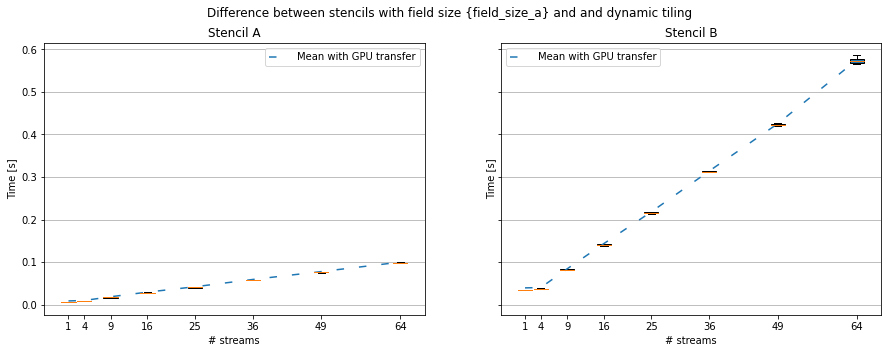

In [7]:

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("Difference between stencils with field size {field_size_a} and and dynamic tiling")


# Stencil A
ax1.grid(axis='y')
ax1.set_title("Stencil A")
ax1.boxplot(np.array(times_a_concur).transpose(), positions = steps_concurrency, **boxplot_options);
mean_times_a = np.mean(times_a_concur, axis=1)
mean_times_transfer_a = np.mean(times_transfer_a_concur, axis=1)
ax1.plot(steps_concurrency, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='# streams', ylabel='Time [s]')
ax1.legend()

# Stencil B

ax2.grid(axis='y')
ax2.set_title("Stencil B")
ax2.boxplot(np.array(times_b_concur).transpose(), positions = steps_concurrency, **boxplot_options);
mean_times_b = np.mean(times_b_concur, axis=1)
mean_times_transfer_b = np.mean(times_transfer_b_concur, axis=1)
ax2.plot(steps_concurrency, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='# streams', ylabel='Time [s]')
ax2.legend()

# Settings
plt.ticklabel_format(axis='y', useOffset=False)

### Performance over grid size
*TODO*

Below the execution time of 10 iterations with the Jacobi Stencil respectively with the Gaussian stencil are shown for different total field sizes are shown. Since the curves run out rather flat towards small grid sizes (up to field sizes of 1024x1024 almost constant times), we can readily read off the overhead of the programm. The overhead becomes -unsurprisingly- bigger with more streams. The actual execution time of the stencil calculations dominates/becomes relevant, depending on the number of streams, only for grid sizes bigger than (1024x1024. Therefore

> Here you can see the overhead very well:
> - up until a field size of 1024,1024 the time is constant, meaning is all overhead
> - the more the # of streams, the more this overhead

In [8]:

# Settings
concurrency_1 = 1
concurrency_2 = 16
concurrency_3 = 64
steps_field_sizes = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

# Setup
times_1_a_field = []
times_1_b_field = []
times_2_a_field = []
times_2_b_field = []
times_3_a_field = []
times_3_b_field = []
times_transfer_1_a_field = []
times_transfer_1_b_field = []
times_transfer_2_a_field = []
times_transfer_2_b_field = []
times_transfer_3_a_field = []
times_transfer_3_b_field = []


for field_size in steps_field_sizes:
    # Setup
    input_field_a = get_initial_field_square((field_size, field_size), n_halo_a)
    input_field_b = get_initial_field_grid((field_size, field_size), n_halo_b)

    
    ## Compute for concurrency 1
    # Stencil A
    temp_times_1_a = []
    temp_times_transfer_1_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_1_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency_1, n_iter, n_halo_a)
        toc = time.perf_counter()
        temp_times_1_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_1_a = temp_output_field_1_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_1_a.append(toc-tic)
        # output_fields_1_a_field.append(temp_output_field_1_a)
        del temp_output_field_1_a_gpu
        del temp_output_field_1_a
        del new_input
        
    times_1_a_field.append(temp_times_1_a)
    times_transfer_1_a_field.append(temp_times_transfer_1_a)
    
    # Stencil B
    temp_times_1_b = []
    temp_times_transfer_1_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_1_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency_1, n_iter, n_halo_b)
        toc = time.perf_counter()
        temp_times_1_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_1_b = temp_output_field_1_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_1_b.append(toc-tic)
        # output_fields_1_b_field.append(temp_output_field_1_b)
        del temp_output_field_1_b_gpu
        del temp_output_field_1_b
        del new_input
        
    times_1_b_field.append(temp_times_1_b)
    times_transfer_1_b_field.append(temp_times_transfer_1_b)

    
    ## Compute for concurrency 2
    # Stencil A
    temp_times_2_a = []
    temp_times_transfer_2_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_2_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency_2, n_iter, n_halo_a)
        toc = time.perf_counter()
        temp_times_2_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_2_a = temp_output_field_2_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_2_a.append(toc-tic)
        # output_fields_2_a_field.append(temp_output_field_2_a)
        del temp_output_field_2_a_gpu
        del temp_output_field_2_a
        del new_input
        
    times_2_a_field.append(temp_times_2_a)
    times_transfer_2_a_field.append(temp_times_transfer_2_a)
    
    # Stencil B
    temp_times_2_b = []
    temp_times_transfer_2_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_2_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency_2, n_iter, n_halo_b)
        toc = time.perf_counter()
        temp_times_2_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_2_b = temp_output_field_2_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_2_b.append(toc-tic)
        # output_fields_2_b_field.append(temp_output_field_2_b)
        del temp_output_field_2_b_gpu
        del temp_output_field_2_b
        del new_input
        
    times_2_b_field.append(temp_times_2_b)
    times_transfer_2_b_field.append(temp_times_transfer_2_b)


    ## Compute for concurrency 3
    # Stencil A
    temp_times_3_a = []
    temp_times_transfer_3_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_3_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency_3, n_iter, n_halo_a)
        toc = time.perf_counter()
        temp_times_3_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_3_a = temp_output_field_3_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_3_a.append(toc-tic)
        # output_fields_3_a_field.append(temp_output_field_3_a)
        del temp_output_field_3_a_gpu
        del temp_output_field_3_a
        del new_input
        
    times_3_a_field.append(temp_times_3_a)
    times_transfer_3_a_field.append(temp_times_transfer_3_a)
    
    # Stencil B
    temp_times_3_b = []
    temp_times_transfer_3_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_3_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency_3, n_iter, n_halo_b)
        toc = time.perf_counter()
        temp_times_3_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_3_b = temp_output_field_3_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_3_b.append(toc-tic)
        # output_fields_3_b_field.append(temp_output_field_3_b)
        del temp_output_field_3_b_gpu
        del temp_output_field_3_b
        del new_input
        
    times_3_b_field.append(temp_times_3_b)
    times_transfer_3_b_field.append(temp_times_transfer_3_b)



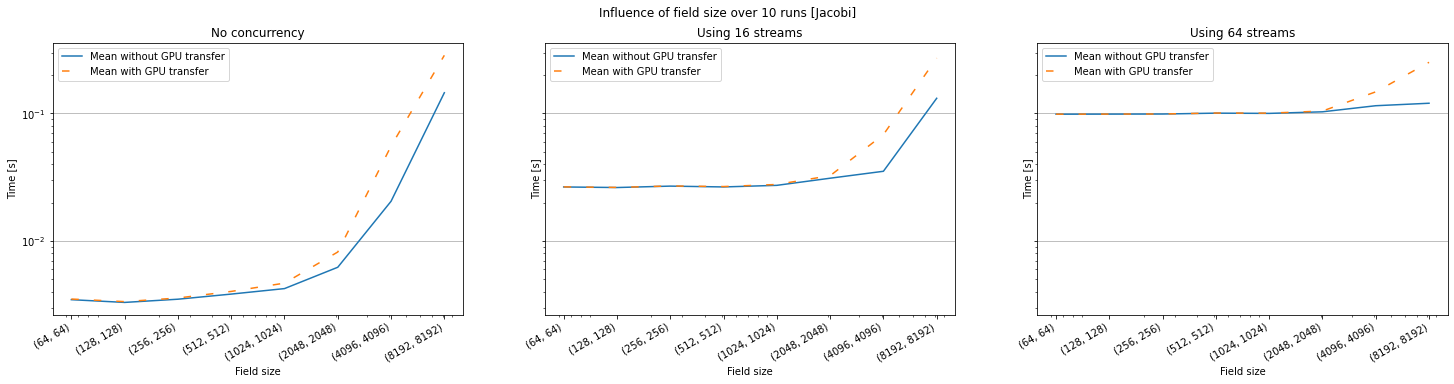

In [9]:
## Stencil A
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle(f"Influence of field size over {n_iter_stats} runs [Jacobi]")

str_steps_field_sizes = [
    f"({s}, {s})" for s in steps_field_sizes
]

# No concurrency
ax1.grid(axis='y')
ax1.set_title(f"No concurrency")
# ax1.boxplot(np.array(times_1_a_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_a = np.mean(times_1_a_field, axis=1)
mean_times_transfer_a = np.mean(times_transfer_1_a_field, axis=1)
ax1.plot(steps_field_sizes, mean_times_a, label="Mean without GPU transfer")
ax1.plot(steps_field_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='Field size', ylabel='Time [s]')
ax1.set_xscale('log')
ax1.xaxis.set_ticks(steps_field_sizes)
ax1.set_xticklabels(str_steps_field_sizes)
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1.set_xticklabels(str_steps_field_sizes)
ax1.legend()

# No concurrency
ax2.grid(axis='y')
ax2.set_title(f"Using {concurrency_2} streams")
# ax2.boxplot(np.array(times_2_a_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_a = np.mean(times_2_a_field, axis=1)
mean_times_transfer_a = np.mean(times_transfer_2_a_field, axis=1)
ax2.plot(steps_field_sizes, mean_times_a, label="Mean without GPU transfer")
ax2.plot(steps_field_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='Field size', ylabel='Time [s]')
ax2.set_xscale('log')
ax2.xaxis.set_ticks(steps_field_sizes)
ax2.set_xticklabels(str_steps_field_sizes)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2.legend()

# No concurrency
ax3.grid(axis='y')
ax3.set_title(f"Using {concurrency_3} streams")
# ax3.boxplot(np.array(times_3_a_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_a = np.mean(times_3_a_field, axis=1)
mean_times_transfer_a = np.mean(times_transfer_3_a_field, axis=1)
ax3.plot(steps_field_sizes, mean_times_a, label="Mean without GPU transfer")
ax3.plot(steps_field_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax3.set(xlabel='Field size', ylabel='Time [s]')
ax3.set_xscale('log')
ax3.xaxis.set_ticks(steps_field_sizes)
ax3.set_xticklabels(str_steps_field_sizes)
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.legend()


ax1.set_yscale('log')
# Settings
# plt.ticklabel_format(axis='y', useOffset=False)

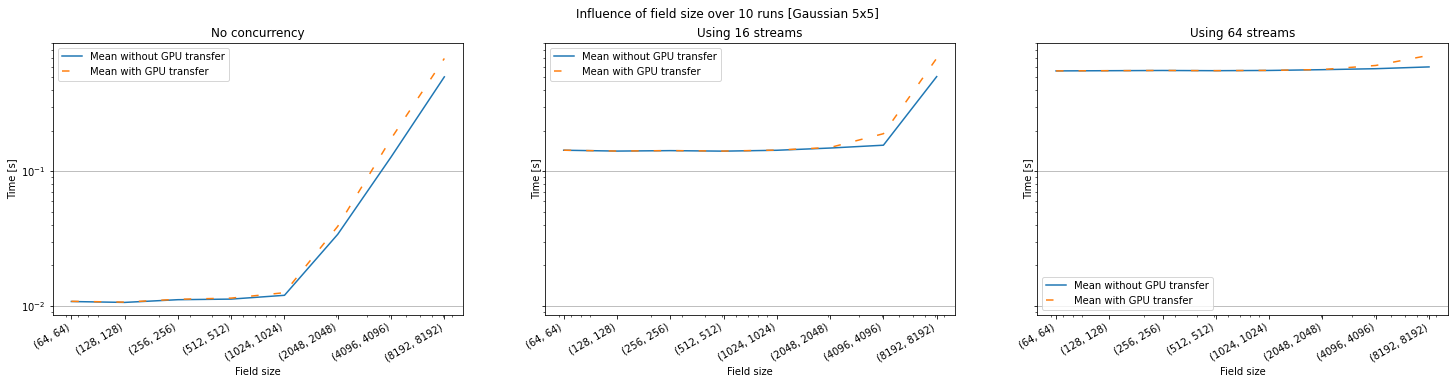

In [10]:
## Stencil B
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle(f"Influence of field size over {n_iter_stats} runs [Gaussian 5x5]")


str_steps_field_sizes = [
    f"({s}, {s})" for s in steps_field_sizes
]

# No concurrency
ax1.grid(axis='y')
ax1.set_title(f"No concurrency")
# ax1.boxplot(np.array(times_1_b_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_b = np.mean(times_1_b_field, axis=1)
mean_times_transfer_b = np.mean(times_transfer_1_b_field, axis=1)
ax1.plot(steps_field_sizes, mean_times_b, label="Mean without GPU transfer")
ax1.plot(steps_field_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='Field size', ylabel='Time [s]')
ax1.set_xscale('log')
ax1.xaxis.set_ticks(steps_field_sizes)
ax1.set_xticklabels(str_steps_field_sizes)
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1.set_xticklabels(str_steps_field_sizes)
ax1.legend()

# No concurrency
ax2.grid(axis='y')
ax2.set_title(f"Using {concurrency_2} streams")
# ax2.boxplot(np.array(times_2_b_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_b = np.mean(times_2_b_field, axis=1)
mean_times_transfer_b = np.mean(times_transfer_2_b_field, axis=1)
ax2.plot(steps_field_sizes, mean_times_b, label="Mean without GPU transfer")
ax2.plot(steps_field_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='Field size', ylabel='Time [s]')
ax2.set_xscale('log')
ax2.xaxis.set_ticks(steps_field_sizes)
ax2.set_xticklabels(str_steps_field_sizes)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2.legend()

# No concurrency
ax3.grid(axis='y')
ax3.set_title(f"Using {concurrency_3} streams")
# ax3.boxplot(np.array(times_3_b_field).transpose(), positions = steps_field_sizes, **boxplot_options);
mean_times_b = np.mean(times_3_b_field, axis=1)
mean_times_transfer_b = np.mean(times_transfer_3_b_field, axis=1)
ax3.plot(steps_field_sizes, mean_times_b, label="Mean without GPU transfer")
ax3.plot(steps_field_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax3.set(xlabel='Field size', ylabel='Time [s]')
ax3.set_xscale('log')
ax3.xaxis.set_ticks(steps_field_sizes)
ax3.set_xticklabels(str_steps_field_sizes)
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.legend()

ax1.set_yscale('log')
# Settings
# plt.ticklabel_format(axis='y', useOffset=False)

## Results fixed tiling
*TODO*

### Varying streams number
*TODO*
> seams it doesn't have an influence if sending all to the gpu synchronously or concurrently on different streams

In [11]:

# Settings
steps_concurrency = [1, 4, 9, 16, 25, 36, 49, 64]
# field_size = (2048, 2048)
field_size = (1024, 1024)
tile_size = (256, 256)

# Setup
input_field_stream_a = get_initial_field_square(field_size, n_halo_a)
input_field_stream_b = get_initial_field_grid(field_size, n_halo_b)
# output_fields_a_stream = []
# output_fields_b_stream = []
times_a_stream = []
times_b_stream = []
times_transfer_a_stream = []
times_transfer_b_stream = []


for concurrency in steps_concurrency:

    # Compute for stencil A
    temp_times_a = []
    temp_times_transfer_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_stream_a)
        tic = time.perf_counter()
        temp_output_field_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency, n_iter, n_halo_a, tile_size)
        toc = time.perf_counter()
        temp_times_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_a = temp_output_field_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_a.append(toc-tic)
        # output_fields_a_stream.append(temp_output_field_a)
        del temp_output_field_a_gpu
        del temp_output_field_a
        del new_input

    times_a_stream.append(temp_times_a)
    times_transfer_a_stream.append(temp_times_transfer_a)
    
    # Compute for stencil B
    temp_times_b = []
    temp_times_transfer_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_stream_b)
        tic = time.perf_counter()
        temp_output_field_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency, n_iter, n_halo_b, tile_size)
        toc = time.perf_counter()
        temp_times_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_b = temp_output_field_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_b.append(toc-tic)
        # output_fields_b_stream.append(temp_output_field_b)
        del temp_output_field_b_gpu
        del temp_output_field_b
        del new_input
        
    times_b_stream.append(temp_times_b)
    times_transfer_b_stream.append(temp_times_transfer_b)


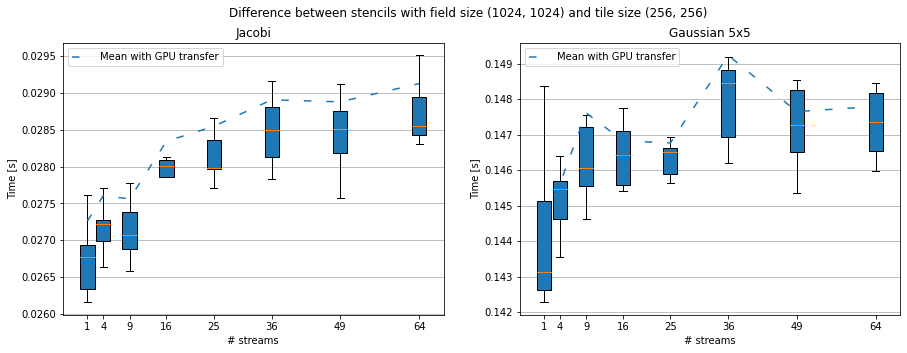

In [12]:

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle(f"Difference between stencils with field size {field_size} and tile size {tile_size}")


# Stencil A
ax1.grid(axis='y')
ax1.set_title("Jacobi")
ax1.boxplot(np.array(times_a_stream).transpose(), positions = steps_concurrency, **boxplot_options);
mean_times_a = np.mean(times_a_stream, axis=1)
mean_times_transfer_a = np.mean(times_transfer_a_stream, axis=1)
ax1.plot(steps_concurrency, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='# streams', ylabel='Time [s]')
ax1.legend()

# Stencil B

ax2.grid(axis='y')
ax2.set_title("Gaussian 5x5")
ax2.boxplot(np.array(times_b_stream).transpose(), positions = steps_concurrency, **boxplot_options);
mean_times_b = np.mean(times_b_stream, axis=1)
mean_times_transfer_b = np.mean(times_transfer_b_stream, axis=1)
ax2.plot(steps_concurrency, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='# streams', ylabel='Time [s]')
ax2.legend()

# Settings
plt.ticklabel_format(axis='y', useOffset=False)

### Varying tile size
*TODO*
> performance decreases incredibly with smaller tiles, but it's not influenced by streams. May explain the overhead seen in the results of the previous section

In [13]:

# Settings
concurrency_1 = 1
concurrency_2 = 16
concurrency_3 = 64
# field_size = (2048, 2048)
field_size = (1024, 1024)
# steps_tile_sizes = [8, 16, 32, 64, 128, 256]
steps_tile_sizes = [32, 64, 128, 256, 512]

# Setup
times_1_a_tile = []
times_1_b_tile = []
times_2_a_tile = []
times_2_b_tile = []
times_3_a_tile = []
times_3_b_tile = []
times_transfer_1_a_tile = []
times_transfer_1_b_tile = []
times_transfer_2_a_tile = []
times_transfer_2_b_tile = []
times_transfer_3_a_tile = []
times_transfer_3_b_tile = []

# Setup
input_field_a = get_initial_field_square(field_size, n_halo_a)
input_field_b = get_initial_field_grid(field_size, n_halo_b)

for t in steps_tile_sizes:
    tile_size = (t,t)
    # print(t)
    
    ## Compute for concurrency 1
    # Stencil A
    temp_times_1_a = []
    temp_times_transfer_1_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_1_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency_1, n_iter, n_halo_a, tile_size)
        toc = time.perf_counter()
        temp_times_1_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_1_a = temp_output_field_1_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_1_a.append(toc-tic)
        # output_fields_1_a_field.append(temp_output_field_1_a)
        del temp_output_field_1_a_gpu
        del temp_output_field_1_a
        del new_input
        
    times_1_a_tile.append(temp_times_1_a)
    times_transfer_1_a_tile.append(temp_times_transfer_1_a)
    
    # Stencil B
    temp_times_1_b = []
    temp_times_transfer_1_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_1_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency_1, n_iter, n_halo_b, tile_size)
        toc = time.perf_counter()
        temp_times_1_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_1_b = temp_output_field_1_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_1_b.append(toc-tic)
        # output_fields_1_b_field.append(temp_output_field_1_b)
        del temp_output_field_1_b_gpu
        del temp_output_field_1_b
        del new_input
        
    times_1_b_tile.append(temp_times_1_b)
    times_transfer_1_b_tile.append(temp_times_transfer_1_b)

    
    ## Compute for concurrency 2
    # Stencil A
    temp_times_2_a = []
    temp_times_transfer_2_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_2_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency_2, n_iter, n_halo_a, tile_size)
        toc = time.perf_counter()
        temp_times_2_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_2_a = temp_output_field_2_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_2_a.append(toc-tic)
        # output_fields_2_a_field.append(temp_output_field_2_a)
        del temp_output_field_2_a_gpu
        del temp_output_field_2_a
        del new_input
        
    times_2_a_tile.append(temp_times_2_a)
    times_transfer_2_a_tile.append(temp_times_transfer_2_a)
    
    # Stencil B
    temp_times_2_b = []
    temp_times_transfer_2_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_2_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency_2, n_iter, n_halo_b, tile_size)
        toc = time.perf_counter()
        temp_times_2_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_2_b = temp_output_field_2_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_2_b.append(toc-tic)
        # output_fields_2_b_field.append(temp_output_field_2_b)
        del temp_output_field_2_b_gpu
        del temp_output_field_2_b
        del new_input
        
    times_2_b_tile.append(temp_times_2_b)
    times_transfer_2_b_tile.append(temp_times_transfer_2_b)


    ## Compute for concurrency 3
    # Stencil A
    temp_times_3_a = []
    temp_times_transfer_3_a = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_a)
        tic = time.perf_counter()
        temp_output_field_3_a_gpu = compute_gpu_2d(new_input, step_stencil_a, concurrency_3, n_iter, n_halo_a, tile_size)
        toc = time.perf_counter()
        temp_times_3_a.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_3_a = temp_output_field_3_a_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_3_a.append(toc-tic)
        # output_fields_3_a_field.append(temp_output_field_3_a)
        del temp_output_field_3_a_gpu
        del temp_output_field_3_a
        del new_input
        
    times_3_a_tile.append(temp_times_3_a)
    times_transfer_3_a_tile.append(temp_times_transfer_3_a)
    
    # Stencil B
    temp_times_3_b = []
    temp_times_transfer_3_b = []
    
    # Iterate for time statistics
    for _ in range(n_iter_stats):
        # Compute
        new_input = cp.copy(input_field_b)
        tic = time.perf_counter()
        temp_output_field_3_b_gpu = compute_gpu_2d(new_input, step_stencil_b, concurrency_3, n_iter, n_halo_b, tile_size)
        toc = time.perf_counter()
        temp_times_3_b.append(toc - tic)
        
        # Get results from GPU
        tic = time.perf_counter()
        temp_output_field_3_b = temp_output_field_3_b_gpu.get()
        toc = time.perf_counter()
        temp_times_transfer_3_b.append(toc-tic)
        # output_fields_3_b_field.append(temp_output_field_3_b)
        del temp_output_field_3_b_gpu
        del temp_output_field_3_b
        del new_input
        
    times_3_b_tile.append(temp_times_3_b)
    times_transfer_3_b_tile.append(temp_times_transfer_3_b)



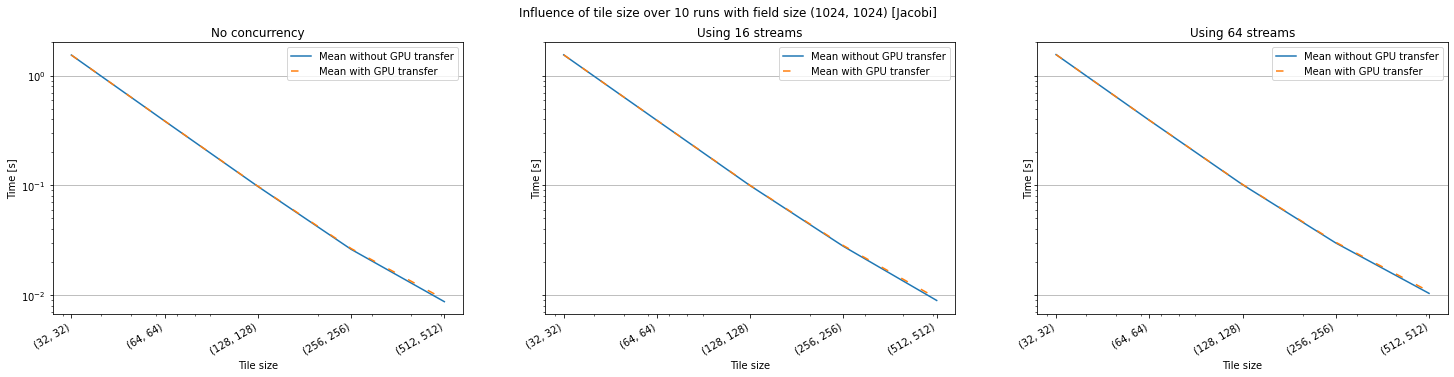

In [14]:
## Stencil A
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle(f"Influence of tile size over {n_iter_stats} runs with field size {field_size} [Jacobi]")

str_steps_tile_sizes = [
    f"({s}, {s})" for s in steps_tile_sizes
]

# No concurrency
ax1.grid(axis='y')
ax1.set_title(f"No concurrency")
# ax1.boxplot(np.array(times_1_a_tile).transpose(), positions = steps_tile_sizes, **boxplot_options);
mean_times_a = np.mean(times_1_a_tile, axis=1)
mean_times_transfer_a = np.mean(times_transfer_1_a_tile, axis=1)
ax1.plot(steps_tile_sizes, mean_times_a, label="Mean without GPU transfer")
ax1.plot(steps_tile_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='Tile size', ylabel='Time [s]')
ax1.set_xscale('log')
ax1.xaxis.set_ticks(steps_tile_sizes)
ax1.set_xticklabels(str_steps_tile_sizes)
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1.set_xticklabels(str_steps_tile_sizes)
ax1.legend()

# No concurrency
ax2.grid(axis='y')
ax2.set_title(f"Using {concurrency_2} streams")
# ax2.boxplot(np.array(times_2_a_tile).transpose(), positions = steps_tile_sizes, **boxplot_options);
mean_times_a = np.mean(times_2_a_tile, axis=1)
mean_times_transfer_a = np.mean(times_transfer_2_a_tile, axis=1)
ax2.plot(steps_tile_sizes, mean_times_a, label="Mean without GPU transfer")
ax2.plot(steps_tile_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='Tile size', ylabel='Time [s]')
ax2.set_xscale('log')
ax2.xaxis.set_ticks(steps_tile_sizes)
ax2.set_xticklabels(str_steps_tile_sizes)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2.legend()

# No concurrency
ax3.grid(axis='y')
ax3.set_title(f"Using {concurrency_3} streams")
# ax3.boxplot(np.array(times_3_a_tile).transpose(), positions = steps_tile_sizes, **boxplot_options);
mean_times_a = np.mean(times_3_a_tile, axis=1)
mean_times_transfer_a = np.mean(times_transfer_3_a_tile, axis=1)
ax3.plot(steps_tile_sizes, mean_times_a, label="Mean without GPU transfer")
ax3.plot(steps_tile_sizes, mean_times_a + mean_times_transfer_a, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax3.set(xlabel='Tile size', ylabel='Time [s]')
ax3.set_xscale('log')
ax3.xaxis.set_ticks(steps_tile_sizes)
ax3.set_xticklabels(str_steps_tile_sizes)
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.legend()


ax1.set_yscale('log')
# Settings
# plt.ticklabel_format(axis='y', useOffset=False)

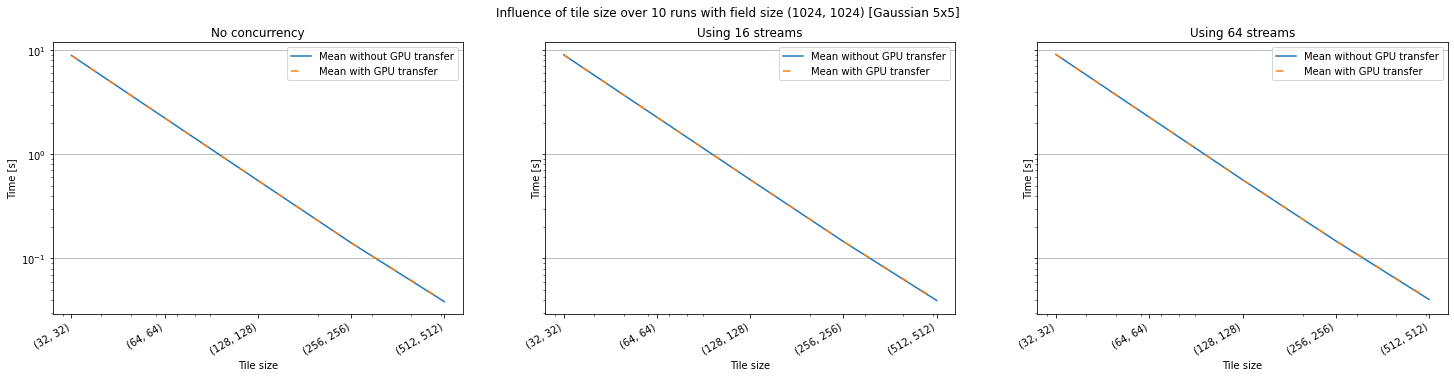

In [15]:
## Stencil B
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle(f"Influence of tile size over {n_iter_stats} runs with field size {field_size} [Gaussian 5x5]")


str_steps_tile_sizes = [
    f"({s}, {s})" for s in steps_tile_sizes
]

# No concurrency
ax1.grid(axis='y')
ax1.set_title(f"No concurrency")
# ax1.boxplot(np.array(times_1_b_tile).transpose(), positions = steps_tile_sizes, **boxplot_options);
mean_times_b = np.mean(times_1_b_tile, axis=1)
mean_times_transfer_b = np.mean(times_transfer_1_b_tile, axis=1)
ax1.plot(steps_tile_sizes, mean_times_b, label="Mean without GPU transfer")
ax1.plot(steps_tile_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax1.set(xlabel='Tile size', ylabel='Time [s]')
ax1.set_xscale('log')
ax1.xaxis.set_ticks(steps_tile_sizes)
ax1.set_xticklabels(str_steps_tile_sizes)
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax1.set_xticklabels(str_steps_tile_sizes)
ax1.legend()

# No concurrency
ax2.grid(axis='y')
ax2.set_title(f"Using {concurrency_2} streams")
# ax2.boxplot(np.array(times_2_b_tile).transpose(), positions = steps_tile_sizes, **boxplot_options);
mean_times_b = np.mean(times_2_b_tile, axis=1)
mean_times_transfer_b = np.mean(times_transfer_2_b_tile, axis=1)
ax2.plot(steps_tile_sizes, mean_times_b, label="Mean without GPU transfer")
ax2.plot(steps_tile_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax2.set(xlabel='Tile size', ylabel='Time [s]')
ax2.set_xscale('log')
ax2.xaxis.set_ticks(steps_tile_sizes)
ax2.set_xticklabels(str_steps_tile_sizes)
for label in ax2.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax2.legend()

# No concurrency
ax3.grid(axis='y')
ax3.set_title(f"Using {concurrency_3} streams")
# ax3.boxplot(np.array(times_3_b_tile).transpose(), positions = steps_tile_sizes, **boxplot_options);
mean_times_b = np.mean(times_3_b_tile, axis=1)
mean_times_transfer_b = np.mean(times_transfer_3_b_tile, axis=1)
ax3.plot(steps_tile_sizes, mean_times_b, label="Mean without GPU transfer")
ax3.plot(steps_tile_sizes, mean_times_b + mean_times_transfer_b, label="Mean with GPU transfer", linestyle=(0,(5,10)))
ax3.set(xlabel='Tile size', ylabel='Time [s]')
ax3.set_xscale('log')
ax3.xaxis.set_ticks(steps_tile_sizes)
ax3.set_xticklabels(str_steps_tile_sizes)
for label in ax3.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax3.legend()

ax1.set_yscale('log')
# Settings
# plt.ticklabel_format(axis='y', useOffset=False)

---

## Discussion
*TODO*

---

## Conclusion
*TODO*